gen	nevals	min    	avg    
0  	500   	6136.29	12990.6
1  	345   	6136.29	10680.5
2  	344   	5577.88	9475.39
3  	347   	5577.88	8872.35
4  	357   	5517.95	8537.96
5  	369   	5340.44	8355.14
6  	356   	5340.44	8082.89
7  	362   	5010.96	7778.55
8  	372   	5010.96	8050.34
9  	360   	5010.96	7836.11
10 	361   	5010.96	7813.42
11 	345   	5010.96	7570.75
12 	364   	5010.96	7362.24
13 	368   	5010.96	7403.01
14 	358   	4989.96	7364.87
15 	374   	4804.22	7508.67
16 	332   	4796.35	7355.15
17 	356   	4734.28	7490.53
18 	356   	4734.28	7454.59
19 	372   	4734.28	7303.79
20 	347   	4796.35	7178.77
21 	374   	4734.28	7113.77
22 	350   	4734.28	7110.62
23 	362   	4506.56	6887.35
24 	358   	4390.05	6703.61
25 	366   	4390.05	6789.76
26 	368   	4390.05	6837.29
27 	377   	4366.48	7024.52
28 	365   	4390.05	6945.17
29 	377   	4366.48	6819.48
30 	352   	4277.27	6843.56
31 	383   	4277.27	6963.54
32 	373   	4277.27	6735.1 
33 	344   	4277.27	6655.69
34 	360   	4277.27	6457.01
35 	337   	4203.9 	6289.14
3

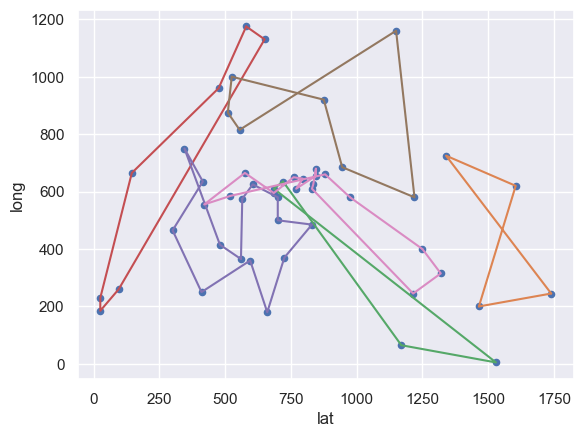

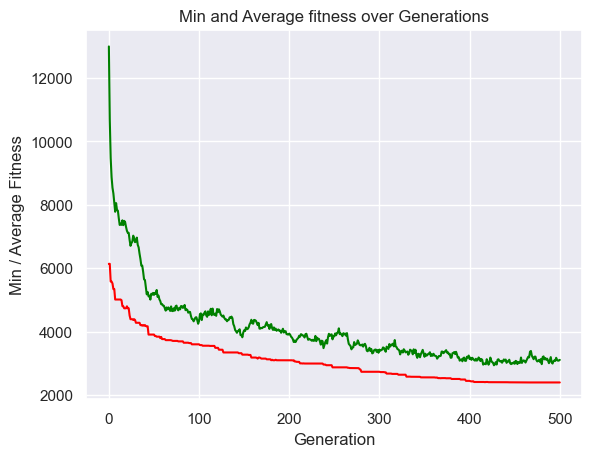

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, shuffle, choice
from deap import creator, base, tools, algorithms
from numpy.random import permutation
from numba import njit, jit

sns.set_theme()


df = pd.read_csv("Berlin Coordinates.csv")


njit()
def split_n_path(path: list, num_locations: int):
    start_index = 0
    sub_paths = []
    for i in range(len(path)):
        if path[i] >= num_locations:
            sub_paths.append(path[start_index:i])
            start_index = i + 1
    sub_paths.append(path[start_index:])

    return sub_paths

njit(parallel=True)
def get_longest_path_length(path: list, num_locations: int):
    # path1, path2, path3 = split_path(path)
    sub_paths = split_n_path(path, num_locations)
    
    longest_path = 0
    for p in sub_paths:
        longest_path = max(longest_path, get_path_length(p))
    #path1_length = get_path_length(path1)
    #path2_length = get_path_length(path2)
    #path3_length = get_path_length(path3)

    return (longest_path, )



jit(nopython=False, parallel=True)
def get_path_length(path: list):
    if len(path) == 0:
        return 0.0
    path_length = 0
    # create two series so that at any index the row in the destination dataframe is the place that comes after the row at the same index in the departing_from dataframe
    departing_from = df.iloc[path[0:-1]].to_numpy()
    destination = df.iloc[path[1:]].to_numpy()
    # reset the index so it doesn't mess up the calculations
    #departing_from.reset_index(inplace=True, drop=True)
    #destination.reset_index(inplace=True, drop=True)
    # calculates delta x squared and delta y squared for every edge in the graph EXCEPT the edge between the last and first node
    location_deltas_squared = (departing_from - destination)**2
    # finish the distance calculation
    point_distances = np.sqrt(location_deltas_squared.sum(axis=1))
    #distances = np.sqrt(np.sum(location_deltas_squared, location_deltas_squared, axis=1))
    # add the distances between the points
    path_length += point_distances.sum()


    # get length from last node to first node
    first_node = df.iloc[[path[0]]]
    last_node = df.iloc[[path[-1]]]
    first_node.reset_index(inplace=True, drop=True)
    last_node.reset_index(inplace=True, drop=True)
    location_deltas_squared = (first_node - last_node)**2
    distances = np.sqrt(location_deltas_squared["lat"] + location_deltas_squared["long"])
    path_length += distances.sum()
    return path_length


def plot_n_paths(path: list, num_locations: int):
    sub_paths = split_n_path(path, num_locations)
    df.plot(kind="scatter", x="lat", y="long")
    color = 1
    for p in sub_paths:
        plot_path(p, color)
        color += 1
        if color >= 10:
            color = 1
        
    plt.show()


def plot_path(path: list, color: int):
    if len(path) == 0:
        return
    values = df.iloc[path]
    x_values = values["lat"]
    y_values = values["long"]
    plt.plot(x_values, y_values, color=sns.color_palette()[color])
    first_and_last = df.iloc[[path[0], path[-1]]]
    x_values = first_and_last["lat"]
    y_values = first_and_last["long"]
    plt.plot(x_values, y_values, color=sns.color_palette()[color])
    




###############################
# settings for the program
population_size = 500
p_crossover = 0.6
p_mutation = 0.3
max_generations = 500
hall_of_fame_size = int(population_size*0.05)
num_locations = df.shape[0]
num_vehicles = 6
genome_length = num_locations + (num_vehicles - 1)


def my_select(individuals, k, tournsize, hof_in, fit_attr: str = "fitness"):
    selected_individuals = tools.selTournament(individuals=individuals, k=len(individuals)-hall_of_fame_size, tournsize=tournsize)
    selected_individuals += hof_in
    shuffle(selected_individuals)
    return selected_individuals

def my_mutate(individual, indpb):
    prob = choice([1.0/54.0, 2.0/54.0, 3.0/54.0])
    return tools.mutShuffleIndexes(individual, prob)

################################
# used to store the greatest individuals who existed, even if they were lost over time
hof = tools.HallOfFame(hall_of_fame_size)



################################
# create the toolbox class and register the functions needed in the toolbox
toolbox = base.Toolbox()
toolbox.register("evaluate", get_longest_path_length, num_locations=num_locations)
toolbox.register("select", my_select, tournsize=3, hof_in=hof)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", my_mutate, indpb=0/54.0)


################################
# create the statistics object and register the necessary functions
stats = tools.Statistics(lambda individual: individual.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)


# create the fitness strategy, this is different than the fitness function, the fitness strategy can contain multiple fitness functions
creator.create("fitness_min", base.Fitness, weights=(-1.0,))
# class used to represent individuals, individuals are represented as lists and use the fitness_min class to measure fitness
creator.create("Individual", list, fitness=creator.fitness_min)


num_delimiters = num_vehicles - 1
genome_example = list(range(num_locations + num_delimiters))
population = [creator.Individual(list(permutation(genome_example))) for _ in range(population_size)]

population, log_book = algorithms.eaSimple(population=population, toolbox=toolbox, cxpb=p_crossover, mutpb=p_mutation, ngen=max_generations, stats=stats, verbose=True, halloffame=hof)
min_fitness_values, mean_fitness_values = log_book.select("min", "avg")
print(hof[0])
print(get_longest_path_length(hof[0], num_locations))
plot_n_paths(hof[0], num_locations)


plt.plot(min_fitness_values, color="red")
plt.plot(mean_fitness_values, color="green")
plt.xlabel("Generation")
plt.ylabel("Min / Average Fitness")
plt.title("Min and Average fitness over Generations")
plt.show()

